::This is an adaptation of the 1.6 with MediaPipe hand model for additin hand detection


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install mediapipe opencv-python-headless tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 15.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyl

In [ ]:
pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 5.6 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import json
import cv2

from sklearn.model_selection import train_test_split
from shutil import copyfile
import os

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from itertools import product

import tensorflow as tf

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

import mediapipe as mp
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.layers import GlobalAveragePooling2D

import visualkeras





processed_BSLdata = '/content/drive/MyDrive/FP/Dataset/dataset2/BSL Digits_resize&pad1'



Hand detection

In [ ]:
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.7)

def process_and_save_images(source_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir, exist_ok=True)

    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        target_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)

        for img_file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                results = hands.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks:
                        # For simplicity, use the bounding box of the first detected hand
                        hand_img = crop_hand_from_image(img, hand_landmarks)
                        if hand_img is not None:
                            cv2.imwrite(os.path.join(target_class_dir, img_file), hand_img)
                        break  # Remove this line if you want to process multiple hands within the same image

def crop_hand_from_image(img, hand_landmarks):
    image_height, image_width, _ = img.shape
    landmark_coords = [(int(landmark.x * image_width), int(landmark.y * image_height)) for landmark in hand_landmarks.landmark]
    x_coords, y_coords = zip(*landmark_coords)
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    # Expand the bounding box slightly to include the whole hand
    x_min, x_max = max(0, x_min - 20), min(image_width, x_max + 20)
    y_min, y_max = max(0, y_min - 20), min(image_height, y_max + 20)
    return img[y_min:y_max, x_min:x_max]

mediapipe_dataset = '/content/drive/MyDrive/FP/VGG16/processed_with_mediapipe6'
process_and_save_images(processed_BSLdata, mediapipe_dataset)

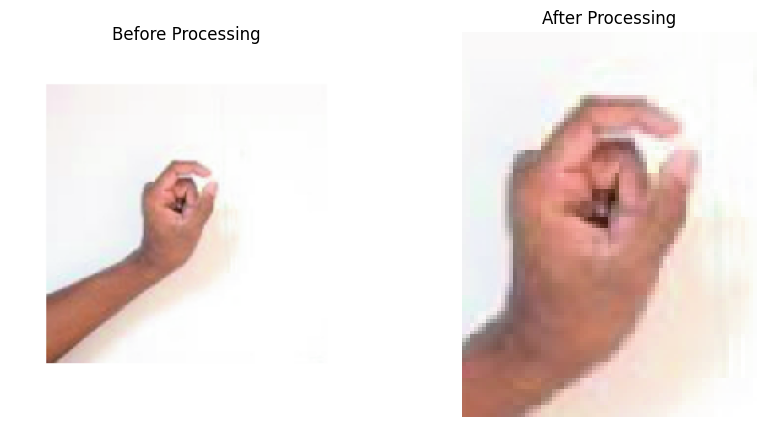

In [ ]:
def show_images(before, after):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))
  ax[0].imshow(cv2.cvtColor(cv2.imread(before), cv2.COLOR_BGR2RGB))
  ax[0].set_title('Before Processing')
  ax[0].axis('off')

  ax[1].imshow(cv2.cvtColor(cv2.imread(after), cv2.COLOR_BGR2RGB))
  ax[1].set_title('After Processing')
  ax[1].axis('off')

  plt.show()


after_image = '/content/drive/MyDrive/FP/VGG16/processed_with_mediapipe6/Input - 0/0 (1).png'
before_image = '/content/drive/MyDrive/FP/Dataset/dataset2/BSL Digits_resize&pad1/Input - 0/0 (1).png'
show_images(before_image, after_image)

normalise

In [ ]:
train_path ='/content/drive/MyDrive/FP/VGG16/Dataset_split/hd_dataset_split6/train'
validation_path ='/content/drive/MyDrive/FP/VGG16/Dataset_split/hd_dataset_split6/validation'
test_path ='/content/drive/MyDrive/FP/VGG16/Dataset_split/hd_dataset_split6/test'

test_split_size = 0.2
validation_split_size_from_train = 0.25

for class_name in os.listdir(mediapipe_dataset):
    # Create paths for each class in train, validation, and test directories
    os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_path, class_name), exist_ok=True)

    # List all files in the current class directory
    class_dir = os.path.join(mediapipe_dataset, class_name)
    all_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

    # Split the data into training+validation and testing sets
    train_val_files, test_files = train_test_split(all_files, test_size=test_split_size, random_state=42)

    # Split the training+validation set into separate training and validation sets
    train_files, validation_files = train_test_split(train_val_files, test_size=validation_split_size_from_train, random_state=42)

    # Function to copy files to the new directory structure
    def copy_files(files, destination):
        for f in files:
            basename = os.path.basename(f)
            copyfile(f, os.path.join(destination, class_name, basename))

    # Copy files to their new locations
    copy_files(train_files, train_path)
    copy_files(validation_files, validation_path)
    copy_files(test_files, test_path)

Augmentation

In [ ]:
def add_perspective_and_rotation(image):
  angle = np.random.randint(0, 360)
  center = (image.shape[1] // 2, image.shape[0] // 2)
  scale = 1
  M = cv2.getRotationMatrix2D(center, angle, scale)
  rotated_img = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

  #perspectine transformation parameters
  ppt = np.float32([[0, 0], [224, 0], [0, 224], [224, 224]])
  ppt2 = ppt + np.random.uniform(-20, 20, size=ppt.shape).astype(np.float32)

  M_ppt = cv2.getPerspectiveTransform(ppt, ppt2)
  ppt_img = cv2.warpPerspective(rotated_img, M_ppt, (224,224))

  return ppt_img

Data Preparation and adding the augmentation

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=lambda x: preprocess_input(add_perspective_and_rotation(x)),
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=30.0)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size = 20

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # VGG16's expected input size
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = validation_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 600 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


In [ ]:
class_indices = train_generator.class_indices
class_indices_json = json.dumps(class_indices)

class_indices_path = '/content/drive/MyDrive/FP/VGG16/Class_indicies/hd_class_indices6.json'

with open(class_indices_path, 'w') as file:
  file.write(class_indices_json)


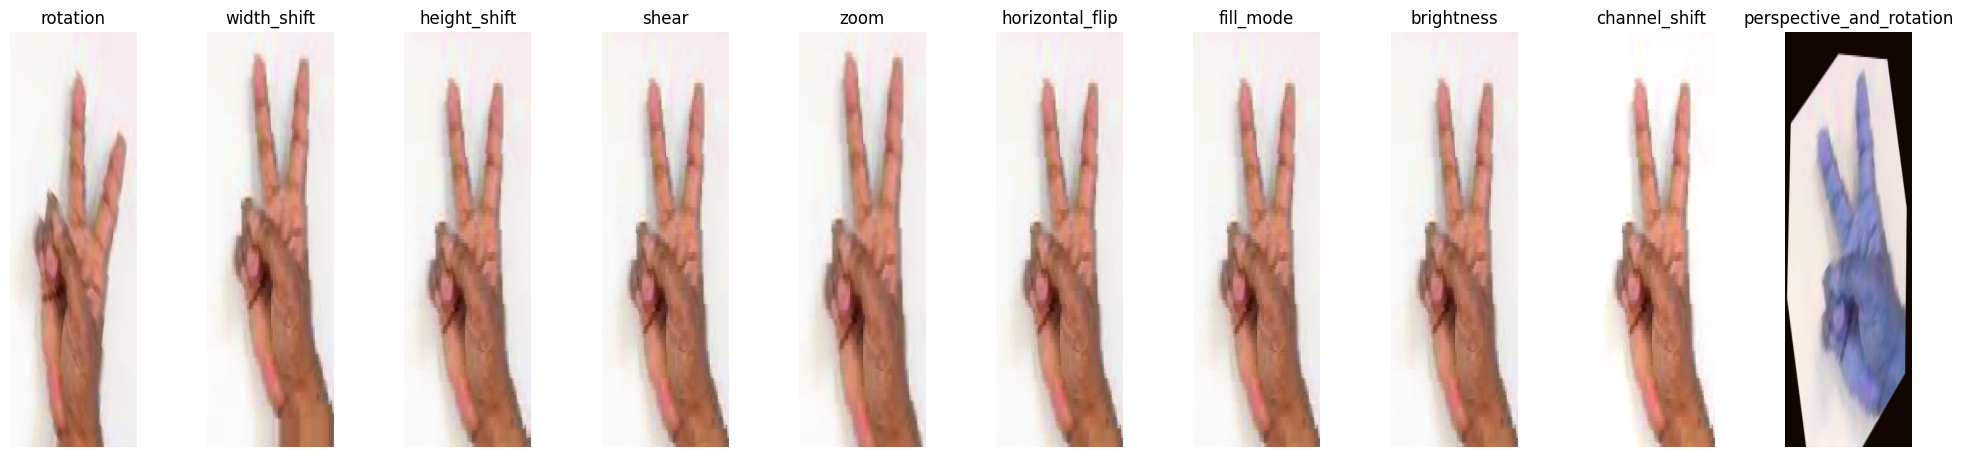

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def show_augmented_images(img_path):
    # Load the image file, converting it to an array
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Reshape it to (1, 224, 224, 3)

    # Define the different augmentations to apply
    augmentation_dict = {
        'rotation': ImageDataGenerator(rotation_range=50),
        'width_shift': ImageDataGenerator(width_shift_range=0.1),
        'height_shift': ImageDataGenerator(height_shift_range=0.1),
        'shear': ImageDataGenerator(shear_range=0.1),
        'zoom': ImageDataGenerator(zoom_range=[0.8, 1.2]),
        'horizontal_flip': ImageDataGenerator(horizontal_flip=True),
        'fill_mode': ImageDataGenerator(fill_mode='nearest'),
        'brightness': ImageDataGenerator(brightness_range=[0.8, 1.2]),
        'channel_shift': ImageDataGenerator(channel_shift_range=30.0),
        'perspective_and_rotation': ImageDataGenerator(preprocessing_function=lambda x: preprocess_input(add_perspective_and_rotation(x)))
    }

    # Plotting each augmented image
    fig, axes = plt.subplots(1, len(augmentation_dict), figsize=(20, 5))
    fig.tight_layout(pad=2.0)

    for ax, (aug_name, aug_gen) in zip(axes, augmentation_dict.items()):
        # Generate augmented image
        for batch in aug_gen.flow(img_array, batch_size=1):
            ax.imshow(image.array_to_img(batch[0]), aspect='auto')
            ax.axis('off')
            ax.set_title(aug_name)
            break

    plt.show()

# Example usage
aug_image_path = '/content/drive/MyDrive/FP/VGG16/Dataset_split/hd_dataset_split6/train/Input - 2/2 (100).png'
show_augmented_images(aug_image_path)

VGG16 model building and hyperparameter tuning

In [ ]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
conv_base.trainable = False

dense_layer = [1]
neurons = [512]
regularizations = [None, regularizers.l2(0.001)]
learning_rates = [1e-4]

best_accuracy = 0
best_configuration = {}

for dl, n, reg, lr in product(dense_layer, neurons, regularizations, learning_rates):
  print(f"Testing configuration: Dense layers={dl}, Neurons={n}, Reg={reg}, LR={lr}")
  vggmodel = Sequential()
  vggmodel.add(conv_base)
  vggmodel.add(GlobalAveragePooling2D())

  for _ in range(dl):
    vggmodel.add(Dense(n, activation='relu', kernel_regularizer=reg))
    vggmodel.add(Dropout(0.5))

  vggmodel.add(layers.Dense(10, activation='softmax'))

  optimizer = Adam(learning_rate=lr)
  vggmodel.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  #Early stopping
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

  #Learning Rate Sceduling
  def scheduler(epoch, lr):
    if epoch < 10:
      return lr
    else:
      return lr * tf.math.exp(-0.05)
  #instantaiting the lr scheduler callback
  lr_schedule = LearningRateScheduler(scheduler)

  #implmenting ModelCheckpoint to monitor the validation acc and save the best model
  model_checkpoint = ModelCheckpoint(
      filepath= '/content/drive/MyDrive/FP/VGG16/Model/BSL_VGG16_HD_Cus_Best_Model6.h5',
      save_best_only= True,
      monitor='val_accuracy',
      mode='max',
      verbose=1)

  callbacks_list = [early_stopping, lr_schedule, model_checkpoint]

  vgghistory = vggmodel.fit(train_generator, steps_per_epoch=train_generator.samples//batch_size,
                       validation_data=validation_generator,
                       validation_steps=validation_generator.samples//batch_size, epochs=20,
                       callbacks=callbacks_list)

  val_accuracy = max(vgghistory.history['val_accuracy'])

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_configuration = {
        'dense_layers': dl,
        'neurons': n,
        'regularizaton': reg,
        'learning_rate': lr}


58889256/58889256 [==============================] - 0s 0us/step
Testing configuration: Dense layers=1, Neurons=512, Reg=None, LR=0.0001
Epoch 1/20
30/30 [==============================] - ETA: 0s - loss: 4.6223 - accuracy: 0.1050
Epoch 1: val_accuracy improved from -inf to 0.20500, saving model to /content/drive/MyDrive/FP/VGG16/Model/BSL_VGG16_HD_Cus_Best_Model6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 23s 532ms/step - loss: 4.6223 - accuracy: 0.1050 - val_loss: 3.0236 - val_accuracy: 0.2050 - lr: 1.0000e-04
Epoch 2/20
30/30 [==============================] - ETA: 0s - loss: 3.4490 - accuracy: 0.1950
Epoch 2: val_accuracy improved from 0.20500 to 0.31500, saving model to /content/drive/MyDrive/FP/VGG16/Model/BSL_VGG16_HD_Cus_Best_Model6.h5
30/30 [==============================] - 16s 541ms/step - loss: 3.4490 - accuracy: 0.1950 - val_loss: 2.4349 - val_accuracy: 0.3150 - lr: 1.0000e-04
Epoch 3/20
30/30 [==============================] - ETA: 0s - loss: 2.6774 - accuracy: 0.2700
Epoch 3: val_accuracy improved from 0.31500 to 0.49000, saving model to /content/drive/MyDrive/FP/VGG16/Model/BSL_VGG16_HD_Cus_Best_Model6.h5
30/30 [==============================] - 18s 596ms/step - loss: 2.6774 - accuracy: 0.2700 - val_loss: 1.8552 - val_accuracy: 0.4900 - lr: 1.0000e-04
Epoch 4/20
30/30 [==============================] - ETA: 0s - loss: 2.2435 - accu

In [ ]:
vggmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 267786 (1.02 MB)
Non-trainable params: 14714688 (56.13 MB)
_________

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
visualkeras.layered_view(vggmodel, to_file='/content/drive/MyDrive/FP/VGG16/vggmodel_visual.png').show()

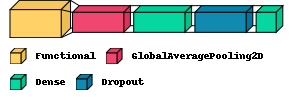

In [ ]:
visualkeras.layered_view(vggmodel, legend=True)

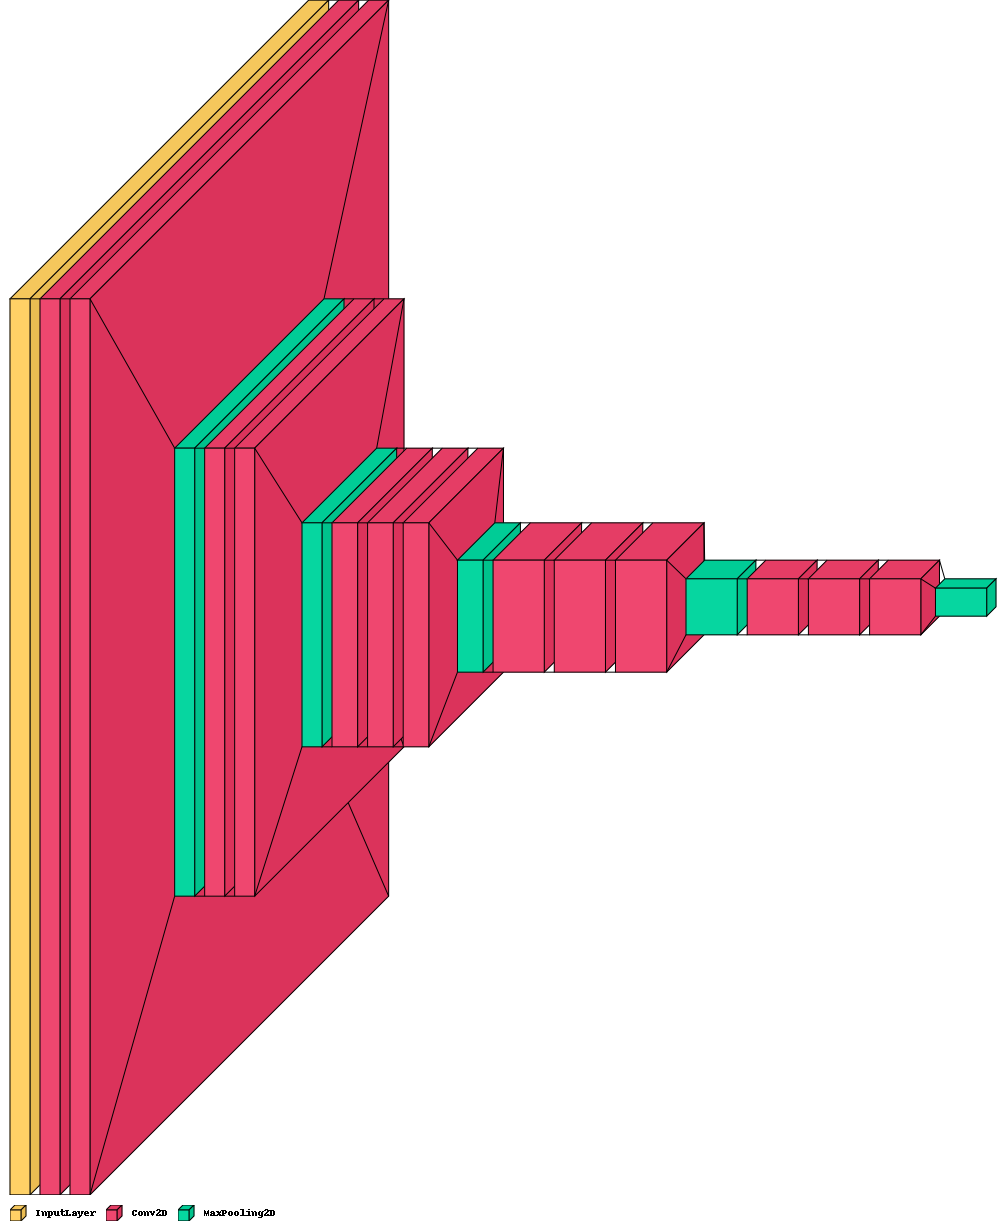

In [ ]:
visualkeras.layered_view(conv_base, legend=True)

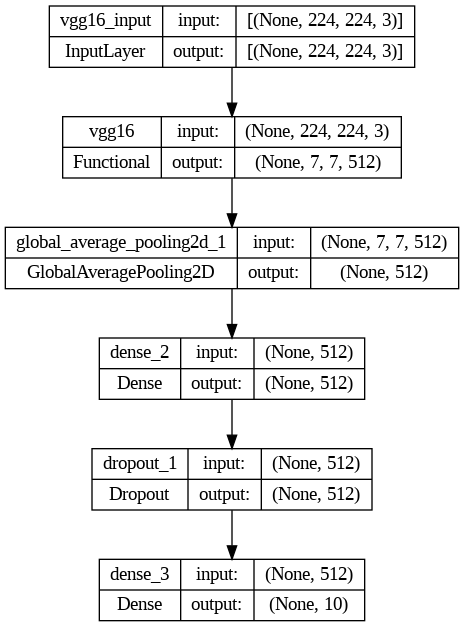

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(vggmodel, to_file='/content/drive/MyDrive/FP/VGG16/vggmodel_visual1.png', show_shapes=True, show_layer_names=True)

In [ ]:
for layer in vggmodel.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print("Layer: ", layer.name, " | Weights shape: ", weights.shape)
        plt.hist(weights.ravel(), bins=50)
        plt.title(layer.name + ' Weight Distribution')
        plt.show()

Model Evaluation on test set

In [ ]:
print("Best Validation Accuracy:", best_accuracy)
print("Best Configuration:", best_configuration)

Best Validation Accuracy: 0.9049999713897705
Best Configuration: {'dense_layers': 1, 'neurons': 512, 'regularizaton': <keras.src.regularizers.L2 object at 0x793f942e51e0>, 'learning_rate': 0.0001}


In [ ]:
initial_test_loss, initial_test_acc = vggmodel.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {initial_test_acc}")

10/10 [==============================] - 2s 164ms/step - loss: 0.7867 - accuracy: 0.8650
Test accuracy: 0.8650000095367432


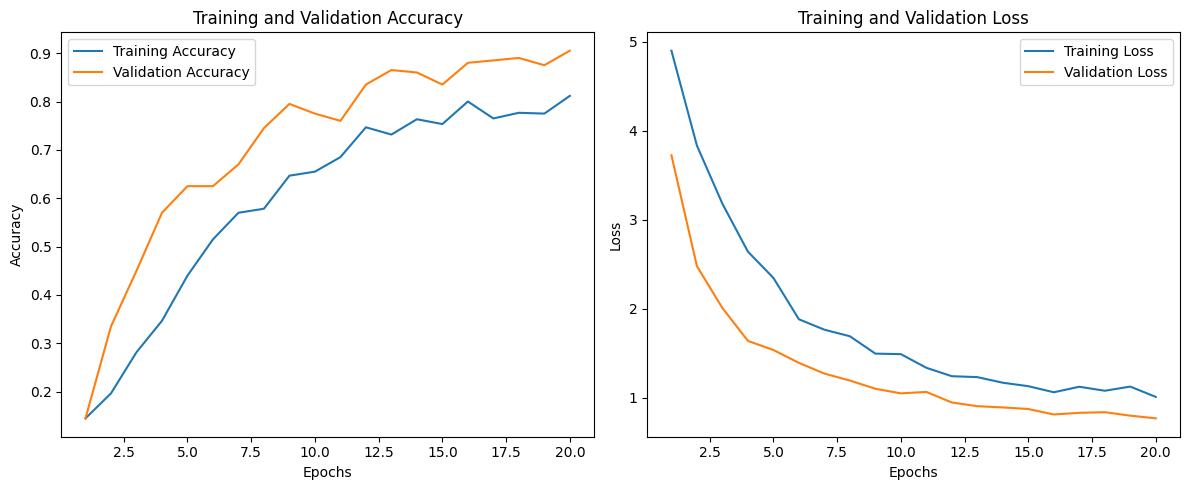

In [ ]:
#learning curve
def plot_learning_curves(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_learning_curves(vgghistory)

10/10 [==============================] - 1s 108ms/step


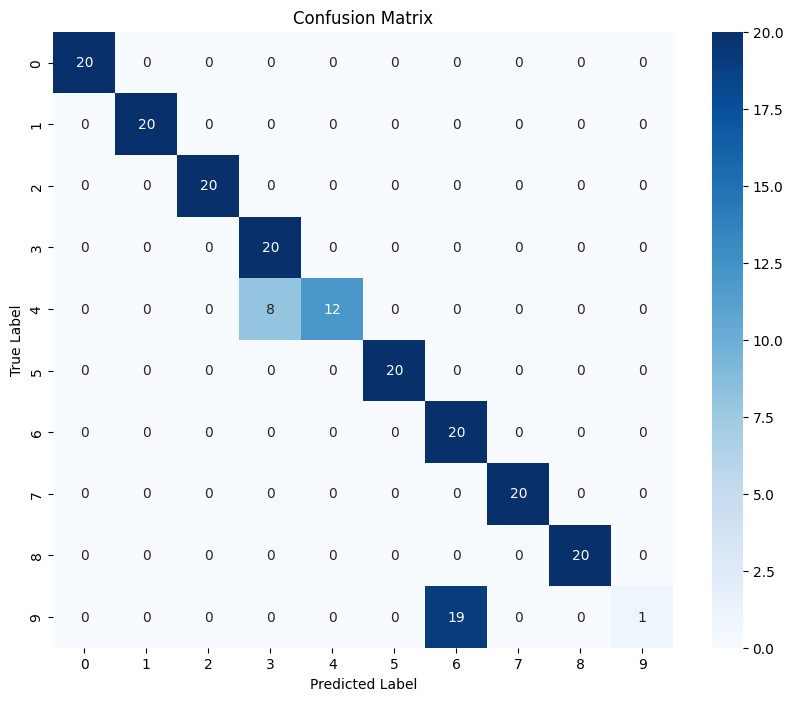

In [ ]:
# Calculate the correct number of steps per epoch for evaluation or prediction
test_steps_per_epoch = np.ceil(test_generator.samples / test_generator.batch_size)

# Use the calculated steps per epoch for prediction
Y_pred = vggmodel.predict(test_generator, steps=test_steps_per_epoch)

# Convert predictions to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Get the true classes
Y_true = test_generator.classes

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(Y_true, Y_pred_classes, target_names=list(train_generator.class_indices.keys()))
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   Input - 0       1.00      1.00      1.00        20
   Input - 1       1.00      1.00      1.00        20
   Input - 2       1.00      1.00      1.00        20
   Input - 3       0.71      1.00      0.83        20
   Input - 4       1.00      0.60      0.75        20
   Input - 5       1.00      1.00      1.00        20
   Input - 6       0.51      1.00      0.68        20
   Input - 7       1.00      1.00      1.00        20
   Input - 8       1.00      1.00      1.00        20
   Input - 9       1.00      0.05      0.10        20

    accuracy                           0.86       200
   macro avg       0.92      0.86      0.84       200
weighted avg       0.92      0.86      0.84       200



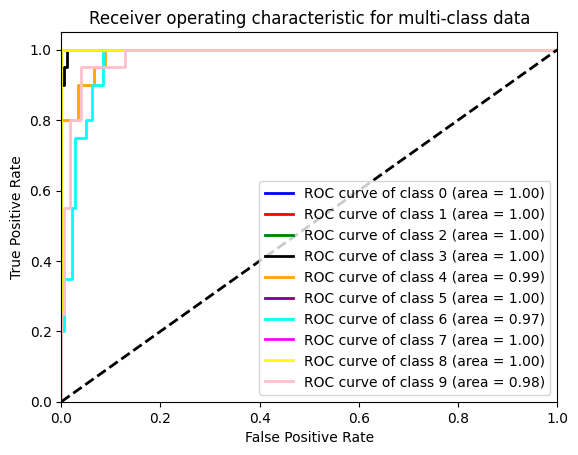

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
Y_true = lb.fit_transform(Y_true)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_true.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_true[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting each class ROC Curve
colors = cycle(['blue', 'red', 'green', 'black', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

Fine Tuning

In [ ]:
# Get class distribution which is needed for class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes)

class_weight_dict = dict(enumerate(class_weights))

conv_base.trainable = True

finetune_layer = 80

#copy all layers except the last from vggmodel
vggmodelFT = Sequential(vggmodel.layers[:-1])
vggmodelFT.add(Dense(10, activation='softmax'))

# ModelCheckpoint for fine-tuning
model_checkpoint_finetuning = ModelCheckpoint(
    filepath='/content/drive/MyDrive/FP/VGG16/Model/BSL_VGG16_Cus_FT_HD_Best_Model6.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1)

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
# Add this updated checkpoint to your callbacks list for fine-tuning
callbacks_list_finetuning = [early_stopping, lr_schedule, model_checkpoint_finetuning]

#gradual unfreezing of conv_base
for layer in conv_base.layers[:finetune_layer]:
  layer.trainable = False
for layer in conv_base.layers[:finetune_layer]:
  layer.trainable = True

vggmodelFT.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

#contiue FT from last epoch of previous training
initial_epochs = vgghistory.epoch[-1]
total_epochs = initial_epochs + 20

vggmodel_finetune_history = vggmodelFT.fit(train_generator,
                                                  epochs=30,
                                                  validation_data=validation_generator,
                                                  callbacks=callbacks_list_finetuning)


Epoch 1/30
30/30 [==============================] - ETA: 0s - loss: 2.7899 - accuracy: 0.1567
Epoch 1: val_accuracy improved from -inf to 0.34000, saving model to /content/drive/MyDrive/FP/VGG16/Model/BSL_VGG16_Cus_FT_HD_Best_Model6.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 21s 561ms/step - loss: 2.7899 - accuracy: 0.1567 - val_loss: 2.5378 - val_accuracy: 0.3400 - lr: 1.0000e-05
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 2.3729 - accuracy: 0.3050
Epoch 2: val_accuracy did not improve from 0.34000
30/30 [==============================] - 16s 519ms/step - loss: 2.3729 - accuracy: 0.3050 - val_loss: 2.0711 - val_accuracy: 0.3250 - lr: 1.0000e-05
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 1.8051 - accuracy: 0.5383
Epoch 3: val_accuracy improved from 0.34000 to 0.87500, saving model to /content/drive/MyDrive/FP/VGG16/Model/BSL_VGG16_Cus_FT_HD_Best_Model6.h5
30/30 [==============================] - 16s 541ms/step - loss: 1.8051 - accuracy: 0.5383 - val_loss: 1.1304 - val_accuracy: 0.8750 - lr: 1.0000e-05
Epoch 4/30
30/30 [==============================] - ETA: 0s - loss: 1.3218 - accuracy: 0.6883
Epoch 4: val_accuracy improved from 0.87500 to 0.91000, saving model to /co

In [ ]:
vggmodelFT.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
Total params: 14982474 (57.15 MB)
Trainable params: 14982474 (57.15 MB)
Non-trainable params: 0 (0.00 Byte)
____________

In [ ]:
visualkeras.layered_view(vggmodelFT, to_file='/content/drive/MyDrive/FP/VGG16/vggmodel_ft_visual.png').show()

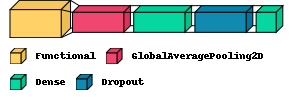

In [ ]:
visualkeras.layered_view(vggmodelFT, legend=True)

Fine tuning model eval

In [ ]:
val_loss, val_acc = vggmodelFT.evaluate(validation_generator, steps=validation_generator.samples // batch_size)

print("Validation Accuracy after fine-tuning:", val_acc)


10/10 [==============================] - 1s 112ms/step - loss: 0.5996 - accuracy: 0.9000
Validation Accuracy after fine-tuning: 0.8999999761581421


In [ ]:
finetuned_test_loss, finetuned_test_acc = vggmodelFT.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f"Test accuracy: {finetuned_test_acc}")

10/10 [==============================] - 1s 107ms/step - loss: 0.5760 - accuracy: 0.9100
Test accuracy: 0.9100000262260437


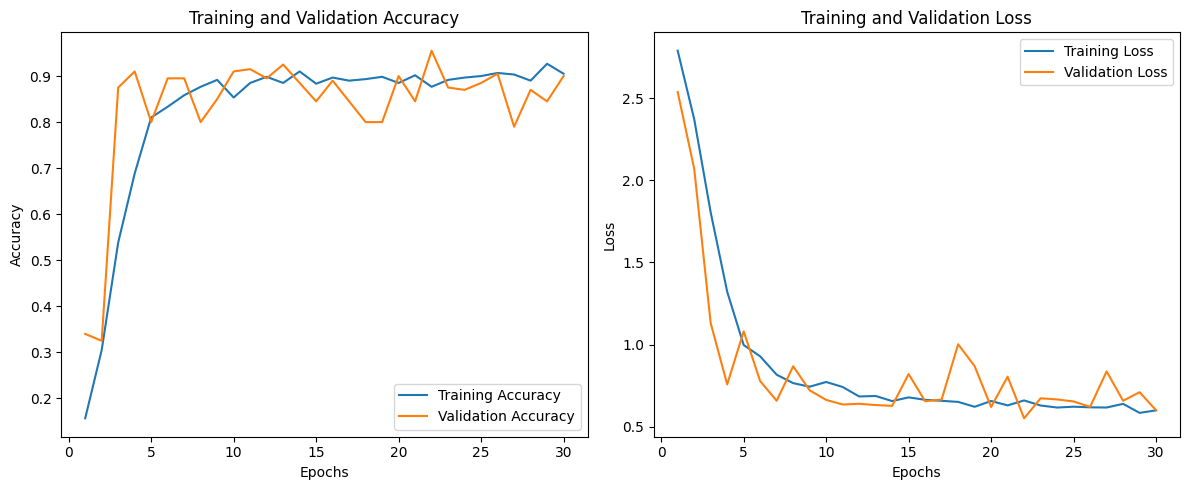

In [ ]:
#learning curve
plot_learning_curves(vggmodel_finetune_history)

10/10 [==============================] - 1s 115ms/step


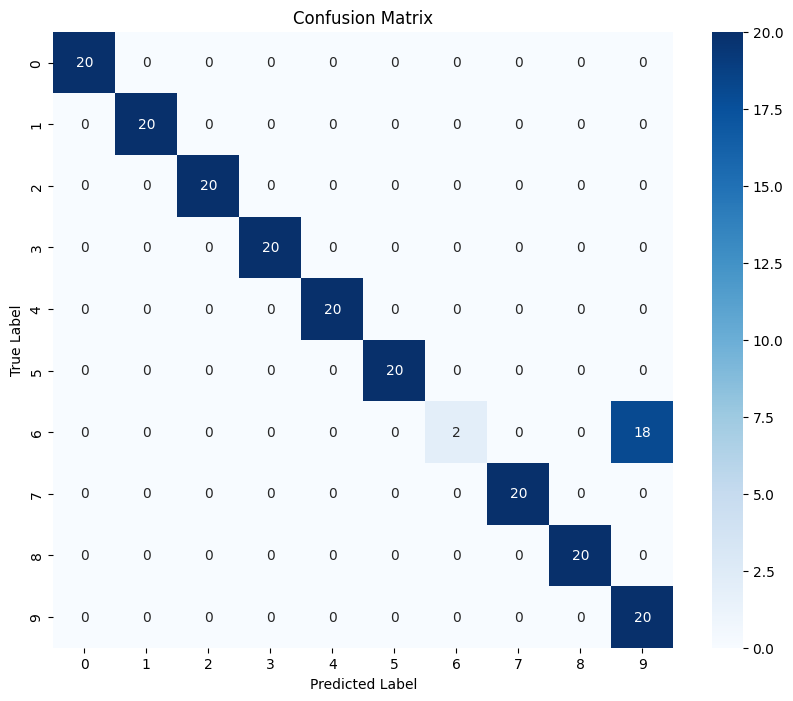

In [ ]:
# Calculate the correct number of steps per epoch for evaluation or prediction
test_steps_per_epoch = np.ceil(test_generator.samples / test_generator.batch_size)

# Use the calculated steps per epoch for prediction
Y_FTpred = vggmodelFT.predict(test_generator, steps=test_steps_per_epoch)

# Convert predictions to one hot vectors
Y_FTpred_classes = np.argmax(Y_FTpred, axis=1)
# Get the true classes
Y_FTtrue = test_generator.classes

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_FTtrue, Y_FTpred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

classification report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(Y_FTtrue, Y_FTpred_classes, target_names=list(train_generator.class_indices.keys()))
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   Input - 0       1.00      1.00      1.00        20
   Input - 1       1.00      1.00      1.00        20
   Input - 2       1.00      1.00      1.00        20
   Input - 3       1.00      1.00      1.00        20
   Input - 4       1.00      1.00      1.00        20
   Input - 5       1.00      1.00      1.00        20
   Input - 6       1.00      0.10      0.18        20
   Input - 7       1.00      1.00      1.00        20
   Input - 8       1.00      1.00      1.00        20
   Input - 9       0.53      1.00      0.69        20

    accuracy                           0.91       200
   macro avg       0.95      0.91      0.89       200
weighted avg       0.95      0.91      0.89       200



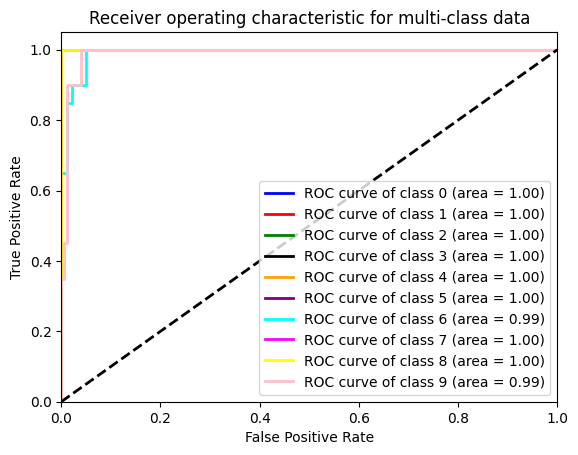

In [ ]:
lb = LabelBinarizer()
Y_FTtrue = lb.fit_transform(Y_FTtrue)

fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_FTtrue.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_FTtrue[:, i], Y_FTpred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting each class ROC Curve
colors = cycle(['blue', 'red', 'green', 'black', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
for layer in vggmodel.layers:
    print(layer.name)

vgg16
global_average_pooling2d_1
dense_2
dropout_1
dense_3


In [ ]:
for layer in vggmodelFT.layers:
    print(layer.name)

vgg16
global_average_pooling2d_1
dense_2
dropout_1
dense_8
